In [1]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)


In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.


In [3]:
df = pd.read_csv('/content/bul.txt',delimiter='\t',header = None).iloc[:,:2]
df.columns = ['eng','bulg']

In [4]:
df

,eng,bulg
0,Hi.,Здрасти.
1,Who?,Кой?
2,Wow!,Уау!
3,Hello!,Здравейте!
4,Cheers!,Наздраве!
...,...,...
15160,Latin Americans know very little about the his...,Латиноамериканците знаят много малко за истори...
15161,The difference between the right word and almo...,Разликата между правилната дума и почти правил...
15162,"Honey, I know the budget is tight, but do you ...","Скъпи, знам, че бюджетът ни е ограничен, но ка..."
15163,Though Tom's English seems quite good at times...,Въпреки че понякога английският на Том изглежд...


In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Loop over lines
for line in df.iterrows():
    # Input and target are split by tabs
    # English TAB French
    input_text = line[1]['eng']
    target_text = line[1]['bulg']
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # Create a set of all unique characters in the input
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # Create a set of all unique output characters
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print('Number of samples:', len(input_texts))

Number of samples: 15165


In [6]:
input_characters = sorted(list(input_characters)) # Make sure we achieve the same order in our input chars
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) # aka size of the english alphabet + numbers, signs, etc.
num_decoder_tokens = len(target_characters) # aka size of the french alphabet + numbers, signs, etc.


print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 73
Number of unique output tokens: 104


In [7]:
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

In [8]:
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # Get longest sequences length
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Max sequence length for inputs: 239
Max sequence length for outputs: 264


In [9]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) 
# containg a one-hot vectorization of the French sentences.

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# decoder_target_data is the same as decoder_input_data but offset by one timestep. 
# decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :]

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Loop over each char in an input text
    for t, char in enumerate(input_text):
        # Create one hot encoding by setting the index to 1
        encoder_input_data[i, t, input_token_index[char]] = 1.
    # Loop over each char in the output text
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [11]:
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name = 'encoder_inputs')

# The return_state contructor argument, configuring a RNN layer to return a list 
# where the first entry is the outputs and the next entries are the internal RNN states. 
# This is used to recover the states of the encoder.
encoder = CuDNNLSTM(latent_dim, 
                    return_state=True, 
                    name = 'encoder')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), 
                       name = 'decoder_inputs')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(latent_dim, 
                         return_sequences=True, 
                         return_state=True, 
                         name = 'decoder_lstm')

# The inital_state call argument, specifying the initial state(s) of a RNN. 
# This is used to pass the encoder states to the decoder as initial states.
# Basically making the first memory of the decoder the encoded semantics
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=40,
                    validation_split=0.2)

Epoch 1/40
190/190 [==============================] - 42s 176ms/step - loss: 0.3467 - val_loss: 0.6942
Epoch 2/40
190/190 [==============================] - 31s 164ms/step - loss: 0.3307 - val_loss: 0.6588
Epoch 3/40
190/190 [==============================] - 31s 163ms/step - loss: 0.3158 - val_loss: 0.5878
Epoch 4/40
190/190 [==============================] - 31s 165ms/step - loss: 0.2992 - val_loss: 0.6646
Epoch 5/40
190/190 [==============================] - 31s 163ms/step - loss: 0.2821 - val_loss: 0.5057
Epoch 6/40
190/190 [==============================] - 31s 164ms/step - loss: 0.2686 - val_loss: 0.5481
Epoch 7/40
190/190 [==============================] - 31s 164ms/step - loss: 0.2595 - val_loss: 0.5801
Epoch 8/40
190/190 [==============================] - 31s 164ms/step - loss: 0.2501 - val_loss: 0.5537
Epoch 9/40
190/190 [==============================] - 31s 163ms/step - loss: 0.2425 - val_loss: 0.5186
Epoch 10/40
190/190 [==============================] - 31s 164ms/step - l

In [13]:
model.save('best.h5')

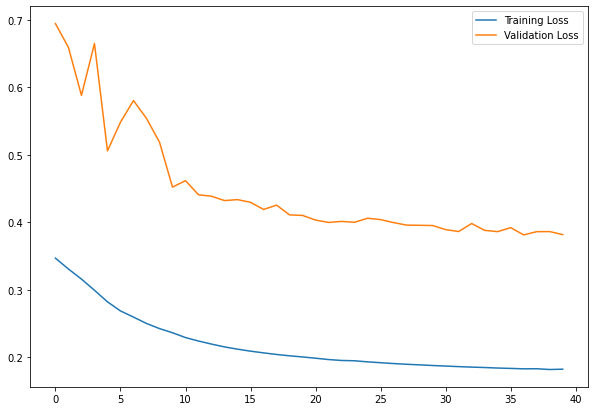

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

In [15]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = {i: char 
                            for char, i in input_token_index.items()}
reverse_target_char_index = {i: char 
                             for char, i in target_token_index.items()}

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    # Loop untill we recieve a stop sign
    while not stop_condition:
        # Get output and internal states of the decoder 
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Get the predicted token (the token with the highest score)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Get the character belonging to the token
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Append char to output
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

my_text = 'Hello, what are you doing?'
placeholder = np.zeros((1,len(my_text)+10,num_encoder_tokens))

In [16]:
for i, char in enumerate(my_text):
    print(i,char, input_token_index[char])
    placeholder[0,i,input_token_index[char]] = 1

0 H 28
1 e 49
2 l 56
3 l 56
4 o 59
5 , 6
6   0
7 w 67
8 h 52
9 a 45
10 t 64
11   0
12 a 45
13 r 62
14 e 49
15   0
16 y 69
17 o 59
18 u 65
19   0
20 d 48
21 o 59
22 i 53
23 n 58
24 g 51
25 ? 20


In [17]:
decode_sequence(placeholder)

'Не съм виждала да се се предина се на Том.\n'

ну такое(


Task 2

In [13]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt


cudnn.benchmark = True
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

dataset = dset.MNIST(root='/content', download=True, 
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
nc=1

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ngpu = 1
nz = 100
ngf = 64
ndf = 64

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Random Seed:  3586
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


100%|██████████| 25/25 [10:47<00:00, 25.89s/it]


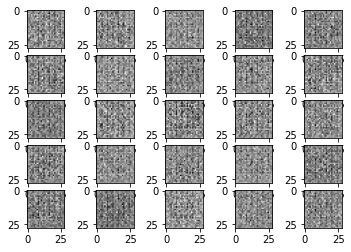

In [15]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

niter = 25
import tqdm

for epoch in tqdm.tqdm(range(niter)):
    for i, data in enumerate(dataloader, 0):
        if i>500:
          break
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device).to(torch.float32)

        output = netD(real_cpu).to(torch.float32)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 100 == 0:
            fake = netG(fixed_noise)
    torch.save(netG.state_dict(), '/content/weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), '/content/weights/netD_epoch_%d.pth' % (epoch))

num_gpu = 1 if torch.cuda.is_available() else 0

# load the models

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()